In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect columns in measurement for future analysis
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


In [10]:
# Inspect columns in station for future analysis
inspector = inspect(engine)
columns = inspector.get_columns("station")
for c in columns:
    print(c['name'])

id
station
name
latitude
longitude
elevation


In [11]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

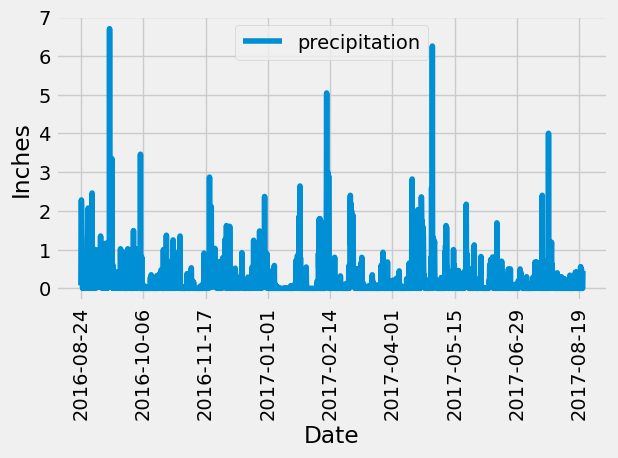

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = [measurement.date,
        measurement.prcp]
yearly_total = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(yearly_total, columns=['Date', 'precipitation'])

# Sort the dataframe by date
df = df.set_index('Date')
df_clean = df.sort_values(by="Date").dropna()

# Use Pandas Plotting with Matplotlib to plot the data
df_clean.plot(rot=90)
plt.ylabel("Inches")
plt.yticks(np.arange(0, 8, 1.0))
plt.tight_layout()
plt.savefig("Output/precipitation_chart.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_clean.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.id)).all()

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station,
       func.count(measurement.station)]
station_counts = session.query(*sel).\
    group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_counts[0][0]

sel = [func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]
session.query(*sel).filter(measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

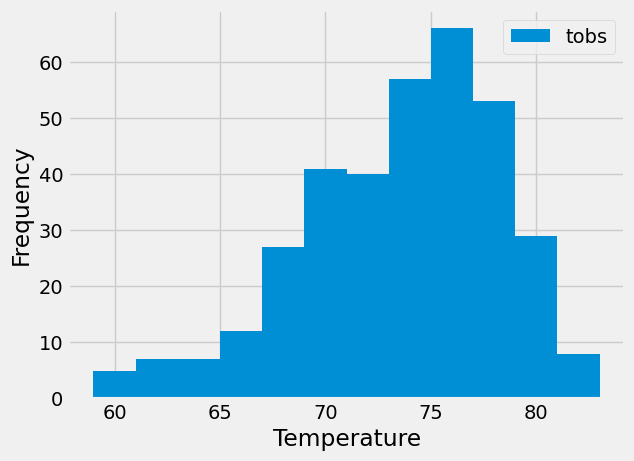

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active = station_counts[0][0]

most_active_tobs = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= year_ago).all()

most_active_df = pd.DataFrame(most_active_tobs)
most_active_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.savefig("Output/tobs_chart")
plt.show()

# Close Session

In [18]:
# Close Session
session.close()